In [46]:
import os
import time
import random

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras

import tensorflow as tf
import tensorflow.keras as keras

SEED = 2024
class_map = {"Happy": 0,
             "Sad": 1,
             "Surprised": 2,
             "Mad": 3}
cache = True

# You may have to change these two
n_epochs = 40
batch_size = 32

IMAGE_SHAPE = 32 # Images will be reshaped to IMAGE_SHAPE x IMAGE_SHAPE
NUM_PIXEL_CHANNELS = 3
INPUT_SHAPE = (IMAGE_SHAPE, IMAGE_SHAPE, NUM_PIXEL_CHANNELS)
LATENT_DIM = 100

# Directory where the data are
data_dir = "/import/software/5dv236/vt24/AffectNet/"
print(f"Loading data from {data_dir}")

# Set seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


gpus = tf.config.experimental.list_physical_devices("GPU")
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print("GPU(s) available. Training will be lightning fast!")
else:
    print("No GPU(s) available. Training will be very slow ...")

PLOT_SETTINGS = {"text.usetex": True,
                 "font.family": "serif",
                 "figure.figsize": (8.0, 6.0),
                 "font.size": 16,
                 "axes.labelsize": 16,
                 "legend.fontsize": 14,
                 "xtick.labelsize": 14,
                 "ytick.labelsize": 14,
                 "axes.titlesize": 24,
                 "lines.linewidth": 2.0,
                 }
plt.rcParams.update(PLOT_SETTINGS)

Loading data from /import/software/5dv236/vt24/AffectNet/
GPU(s) available. Training will be lightning fast!


In [47]:
class DataLoader(keras.utils.Sequence):
    """A simple data loader for Assignment 1.

    Note: Do not make changes to the data loader!
    """

    def __init__(self,
                 data_path,
                 class_map,
                 batch_size=32,
                 cache=True,
                 random_state=None,
                 dtype=np.uint8,
                 ):

        self.data_path = data_path
        self.class_map = class_map
        self.batch_size = max(1, int(batch_size))
        self.cache = bool(cache)
        if random_state is None:
            self.random_state = np.random
        elif isinstance(random_state, np.random.RandomState):
            self.random_state = random_state
        else:
            self.random_state = np.random.RandomState(random_state)
        self.dtype = dtype

        if self.data_path is None:
            raise ValueError('The data path is not defined.')

        if not os.path.isdir(self.data_path):
            raise ValueError('The data path is incorrectly defined.')

        if not isinstance(self.class_map, dict):
            raise ValueError('The folder map is not a dictionary.')

        # Read the files in all subfolders
        self._file_idx = 0
        self._images = []
        self._labels = []
        for folder in self.class_map:
            path = os.path.join(self.data_path, folder)
            for file in os.listdir(path):
                file_path = os.path.join(path, file)
                self._images.append(file_path)
                self._labels.append(folder)

        self._image_cache = dict()

        self.on_epoch_end()

    def __len__(self):
        """Get the number of mini-batches per epoch."""
        return int(len(self._images) / self.batch_size)

    def __getitem__(self, index):
        """Get one batch of data."""
        # Generate indices of the batch
        indices = self._indices[
            index * self.batch_size:(index + 1) * self.batch_size]

        # Find the next set of file indices
        minibatch_files = [self._images[k] for k in indices]
        minibatch_labels = [self.class_map[self._labels[k]] for k in indices]

        # Load up the corresponding minibatch
        minibatch = self.__load_minibatch(minibatch_files)

        return minibatch, minibatch_labels

    def on_epoch_end(self):
        """Update indices after each epoch."""
        self._indices = np.arange(len(self._images))
        self.random_state.shuffle(self._indices)

    def __load_image(self, file):
        """Load a single image from file."""
        im = Image.open(file)
        if im.mode != "RGB":
            im = im.convert("RGB")
        
        im = im.resize((IMAGE_SHAPE, IMAGE_SHAPE), Image.ANTIALIAS)
        im = np.asarray(im, dtype=self.dtype)

        return im

    def __load_minibatch(self, minibatch_files):
        """Load the next minibatch of samples."""

        try:
            assert self.batch_size == len(minibatch_files)
        except AssertionError:
            print(self.batch_size)
            print(len(minibatch_files))

        minibatch = [None] * self.batch_size
        for i, file in enumerate(minibatch_files):
            if self.cache:
                if file in self._image_cache:
                    im = self._image_cache[file]
                else:
                    im = np.asarray(Image.open(file))
                    im = self.__load_image(file)
                    self._image_cache[file] = im
            else:
                im = self.__load_image(file)

            minibatch[i] = im

        return minibatch

In [49]:
# Create the data loaders
train_ds = DataLoader(os.path.join(data_dir, "train/"),
                      class_map=class_map,
                      batch_size=batch_size,
                      cache=cache,
                      )
val_ds = DataLoader(os.path.join(data_dir, "val/"),
                    class_map=class_map,
                    batch_size=batch_size,
                    cache=cache,
                    )
# Do not use the test data in any way until the very end, when you fill in the
# values in your report just before handing it in!
test_ds = DataLoader(os.path.join(data_dir, "test/"),
                     class_map=class_map,
                     batch_size=batch_size,
                     cache=cache,
                     )

# A quick summary of the data:
print(f"Number of training mini-batches: {len(train_ds)}")
print(f"Number of training images      : {len(train_ds._indices)}")
print(f"Number of validation images    : {len(val_ds._indices)}")
print(f"Number of test images          : {len(test_ds._indices)}")


print(f"\nImage shape: {np.array(train_ds[0][0][0]).shape}")

Number of training mini-batches: 250
Number of training images      : 8000
Number of validation images    : 1000
Number of test images          : 1000

Image shape: (32, 32, 3)


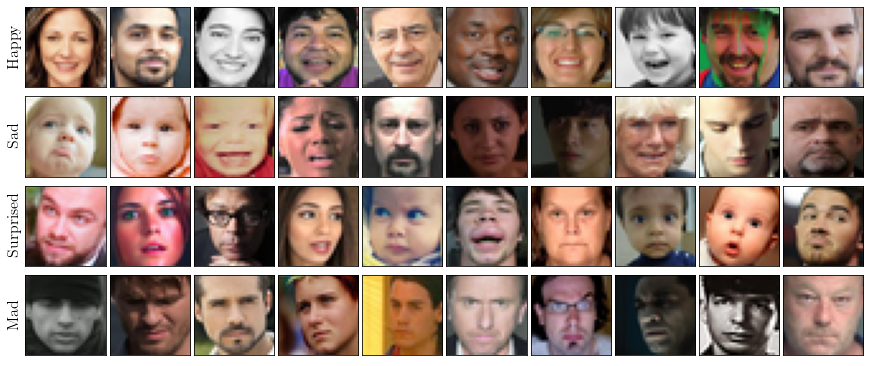

In [50]:
# Plot a few of the training images
fig = plt.figure(figsize=(12, 5))
fig.subplots_adjust(top=0.995,
                    bottom=0.005,
                    left=0.025,
                    right=0.995,
                    wspace=0.05,
                    hspace=0.0125)
M, N = 4, 10
axs = []
for m in range(M):
    axs.append([])
    for n in range(N):
        ax = plt.subplot2grid((M, N), (m, n), rowspan=1, colspan=1)
        ax.xaxis.set_ticklabels([])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticklabels([])
        ax.yaxis.set_ticks([])
        axs[m].append(ax)

imgs = []
lbls = []
for i in range(3):
    imgs.extend(train_ds[i][0])
    lbls.extend(train_ds[i][1])
indices = [0] * 4
for i in range(len(imgs)):
    y = lbls[i]
    if indices[y] < N:
        axs[y][indices[y]].imshow(imgs[i].astype(int))  # int [0,...,255]
        indices[y] += 1
for m in range(M):
    label = list(train_ds.class_map.keys())[
        list(train_ds.class_map.values()).index(m)]
    axs[m][0].set_ylabel(f"{label}")

In [51]:
# Models inspired by: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/


def discriminator():
    # TODO: fix correct input shape for face images
    INPUT_SHAPE = (28,28,1)
    discriminator_model = tf.keras.models.Sequential(name="discriminator")
    discriminator_model.add(tf.keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=INPUT_SHAPE))
    discriminator_model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    discriminator_model.add(tf.keras.layers.Dropout(0.4))
    discriminator_model.add(tf.keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    discriminator_model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    discriminator_model.add(tf.keras.layers.Dropout(0.4))
    discriminator_model.add(tf.keras.layers.Flatten())
    discriminator_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    discriminator_model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
    return discriminator_model
 

def generator():
    generator_model = tf.keras.models.Sequential(name="generator")
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    generator_model.add(tf.keras.layers.Dense(n_nodes, input_dim=LATENT_DIM))
    generator_model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    generator_model.add(tf.keras.layers.Reshape((7, 7, 128)))
    # upsample to 14x14
    generator_model.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    generator_model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    # upsample to 28x28
    generator_model.add(tf.keras.layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    generator_model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
    generator_model.add(tf.keras.layers.Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return generator_model
 

def gan(generator_model, discriminator_model):
   discriminator_model.trainable = False # freez discirminator
   model = tf.keras.models.Sequential(name="GAN")
   model.add(generator_model)
   model.add(discriminator_model)
   model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5))
   return model

def get_latent_batch():
    return np.randn(LATENT_DIM * batch_size).reshape(batch_size, LATENT_DIM)

def generate_fake_batch(generator_model):
    x_input = get_latent_batch()
    X = generator_model.predict(x_input)
    # fake class labels (0)
    y = np.zeros((batch_size, 1))
    return X, y




VERBOSE_LEVEL = 0

disc_model = discriminator()
gen_model = generator()
gan = gan(gen_model, disc_model)

if VERBOSE_LEVEL > 1:
    disc_model.summary()
    gen_model.summary()
    gan.summary()